## 例7-3. k-meansによる特徴量生成

In [2]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder

class KMeansFeaturizer:
    """
    数値データをk-meansのクラスタIDに変換します。
    
    この変換器は入力データに対してk-meansを実行し、各データポイントを最も近い
    クラスタのIDに変換します。ターゲット変数yが存在する場合、クラス分類の境界を
    より重視したクラスタリングの結果を得るために、ターゲット変数をスケーリングして
    入力データに含めてk-meansに渡します。
    """
    
    def __init__(self, k=100, target_scale=5.0, random_state=None):
        self.k = k
        self.target_scale = target_scale
        self.random_state = random_state
        self.cluster_encoder = OneHotEncoder(categories='auto').fit(np.array(range(k)).reshape(-1,1))
        
    def fit(self, X, y=None):
        """
        入力データに対しk-meansを実行し、各クラスタの中心を見つけます。
        """
        if y is None:
            # ターゲット変数がない場合、ふつうのk-meansを実行します。
            km_model = KMeans(n_clusters=self.k, n_init=20, random_state=self.random_state)
            km_model.fit(X)
            self.km_model_ = km_model
            self.cluster_centers_ = km_model.cluster_centers_
            return self

        # ターゲット変数がある場合。スケーリングして入力データに含めます。
        data_with_target = np.hstack((X, y[:,np.newaxis]*self.target_scale))

        # ターゲットを組み入れたデータで事前学習するためのk-meansモデルを構築します。
        km_model_pretrain = KMeans(n_clusters=self.k, n_init=20, random_state=self.random_state)
        km_model_pretrain.fit(data_with_target)

        # ターゲット変数の情報を除いて元の空間におけるクラスタを得るために
        # k-meansを再度実行します。事前学習で見つけたクラスタの中心を
        # 使って初期化し、クラスタの割り当てと中心の再計算を1回にします。
        km_model = KMeans(n_clusters=self.k, init=km_model_pretrain.cluster_centers_[:,:2], n_init=1, max_iter=1)
        km_model.fit(X)
        
        self.km_model = km_model
        self.cluster_centers_ = km_model.cluster_centers_
        return self
    
    def transform(self, X, y=None):
        """
        入力データポイントに最も近いクラスタのIDを返します。
        """
        clusters = self.km_model.predict(X)
        return self.cluster_encoder.transform(clusters.reshape(-1,1))
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)

## ターゲット変数の有無によるk-meansの結果の違い

In [3]:
%matplotlib notebook
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

training_data, training_labels = make_moons(n_samples=2000, noise=0.2)
kmf_hint = KMeansFeaturizer(k=100, target_scale=10).fit(training_data, training_labels)
kmf_no_hint = KMeansFeaturizer(k=100, target_scale=0).fit(training_data, training_labels)

<IPython.core.display.Javascript object>


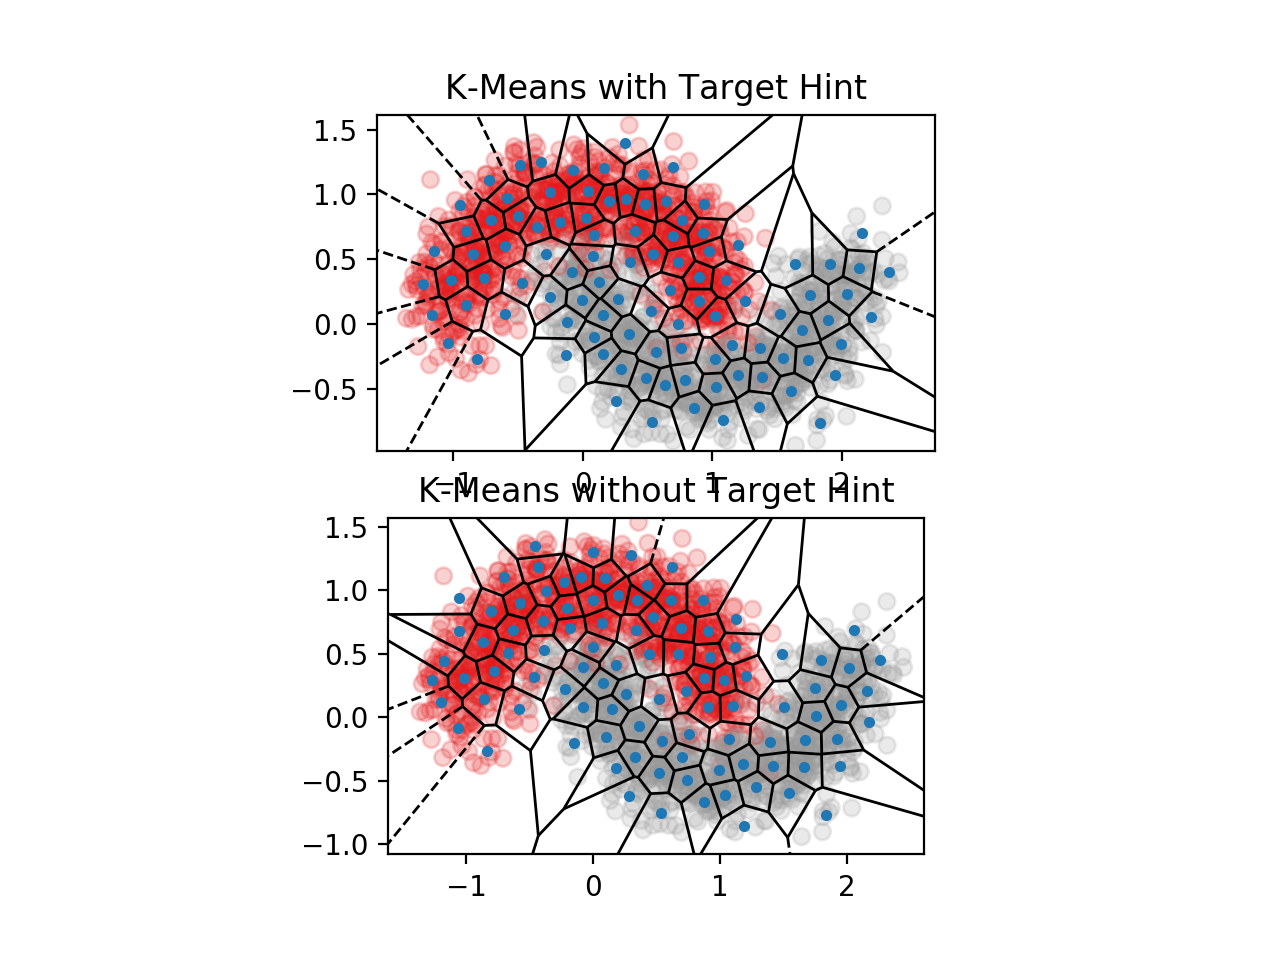

Text(0.5, 1.0, 'K-Means without Target Hint')

In [5]:
def kmeans_voronoi_plot(X, y, cluster_centers, ax):
   """
   k-meansのクラスタの境界からボロノイ図を描き、データに重ね合わせます
   """
   ax.scatter(X[:, 0], X[:, 1], c=y, cmap='Set1', alpha=0.2)
    
   # voronoi_plot_2d関数内で、ishold関数が利用されているが、matplotlib 2.0以降では廃止されているため設定
   def ishold():
       return True
   ax.ishold = ishold
    
   vor = Voronoi(cluster_centers)
   voronoi_plot_2d(vor, ax=ax, show_vertices=False, alpha=0.5)

fig = plt.figure()
ax = plt.subplot(211, aspect='equal')
kmeans_voronoi_plot(training_data, training_labels, kmf_hint.cluster_centers_, ax)
ax.set_title('K-Means with Target Hint')
ax2 = plt.subplot(212, aspect='equal')
kmeans_voronoi_plot(training_data, training_labels, kmf_no_hint.cluster_centers_, ax2)
ax2.set_title('K-Means without Target Hint')

## k-meansで生成したクラスタ特徴量を用いたクラス分類

<IPython.core.display.Javascript object>


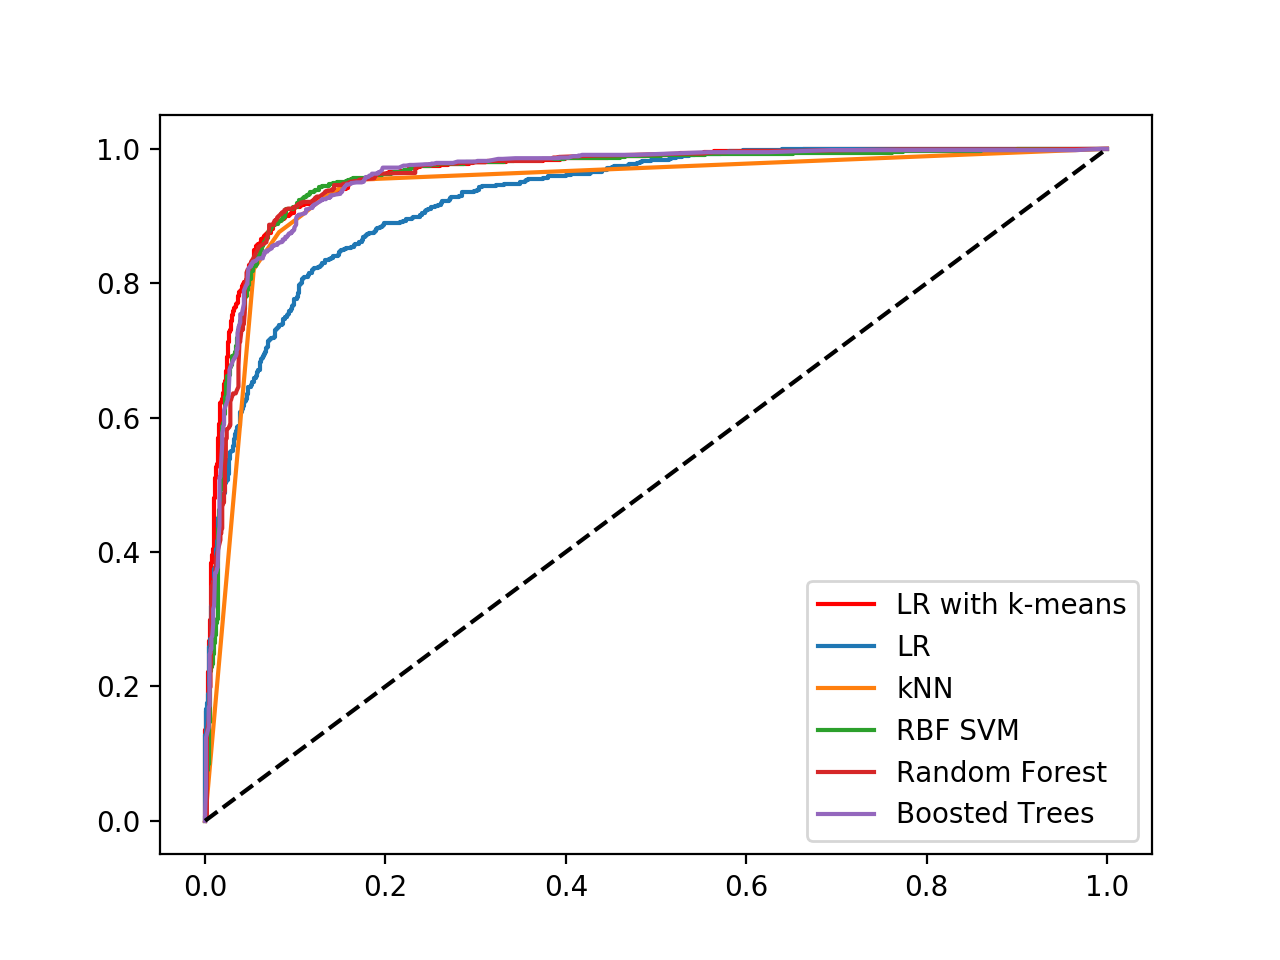

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import sklearn
import scipy

seed = 1

### 学習データと同じ分布からテストデータを生成する
test_data, test_labels = make_moons(n_samples=2000, noise=0.3)

### クラスタID（クラスタ特徴量）を得るために先ほどのk-meansの結果を使う
training_cluster_features = kmf_hint.transform(training_data)
test_cluster_features = kmf_hint.transform(test_data)

### クラスタ特徴量を入力特徴量に追加する
training_with_cluster = scipy.sparse.hstack((training_data, training_cluster_features))
test_with_cluster = scipy.sparse.hstack((test_data, test_cluster_features))


### クラス分類を実行する
lr_cluster = LogisticRegression(solver='liblinear', random_state=seed).fit(training_with_cluster, training_labels)


classifier_names = ['LR',
                    'kNN',
                    'RBF SVM',
                    'Random Forest',
                    'Boosted Trees']


classifiers = [LogisticRegression(solver='liblinear', random_state=seed),
               KNeighborsClassifier(5),
               SVC(gamma=2, C=1),
               RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
               GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, max_depth=5)]

for model in classifiers:
    model.fit(training_data, training_labels)

### クラス分類の性能をROC曲線を使って評価するためのヘルパ関数
def test_roc(model, data, labels):
    if hasattr(model, "decision_function"):
        predictions = model.decision_function(data)
    else:
        predictions = model.predict_proba(data)[:,1]
    fpr, tpr, _ = sklearn.metrics.roc_curve(labels, predictions)
    return fpr, tpr

### 結果をプロット
import matplotlib.pyplot as plt
plt.figure()
fpr_cluster, tpr_cluster = test_roc(lr_cluster, test_with_cluster, test_labels)
plt.plot(fpr_cluster, tpr_cluster, 'r-', label='LR with k-means')

for i, model in enumerate(classifiers):
    fpr, tpr = test_roc(model, test_data, test_labels)
    plt.plot(fpr, tpr, label=classifier_names[i])

plt.plot([0, 1], [0, 1], 'k--')
plt.legend()